
# Week 3 Lab — Mobile System Evaluation Framework (mmWave Screen Attack Detection)

**Course:** CSCI 4771 / 5771 — Mobile Computing  
**Author:** Shivam Pathak 
**Date:** 2025-09-07

- Task 1: Basic performance evaluation 
- Task 2: Robustness testing across distance, interference, cross-device, and real-world scenarios.
- Task 3: Comprehensive Evaluation Report




## Setup




In [16]:
!{sys.executable} -m pip install matplotlib numpy scipy pandas scikit-learn seaborn



zsh:1: parse error near `-m'


In [17]:

# If needed, install dependencies (run once):



%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# Reproducibility
# -------------------------
np.random.seed(42)



## Mobile System Simulator




In [18]:

class MobileSystemSimulator:
    """Simulates mobile sensing system for screen attack detection"""
    def __init__(self, sample_rate=10_000):
        # Use sufficiently high fs so synthetic activity freqs are representable
        self.sample_rate = sample_rate
        self.activities = ['MS_Word', 'Gmail', 'Facebook', 'Online_Banking', 'PDF_Reader', 'YouTube', 'System_Login']
        self.device_types = ['Desktop', 'Laptop', 'Smartphone', 'Tablet']

    def simulate_mmwave_signature(self, activity, device_type, duration=1.0, noise_level=0.10):
        """Simulate mmWave frequency response for different screen activities"""
        t = np.linspace(0, duration, int(duration * self.sample_rate), endpoint=False)

        # Base frequency signatures for different activities (Hz)
        activity_signatures = {
            'MS_Word':        {'freq': 1500, 'amplitude': 0.8, 'pattern': 'text'},
            'Gmail':          {'freq': 2200, 'amplitude': 0.9, 'pattern': 'interface'},
            'Facebook':       {'freq': 1800, 'amplitude': 0.7, 'pattern': 'social'},
            'Online_Banking': {'freq': 2500, 'amplitude': 1.0, 'pattern': 'secure'},
            'PDF_Reader':     {'freq': 1200, 'amplitude': 0.6, 'pattern': 'document'},
            'YouTube':        {'freq': 3000, 'amplitude': 1.2, 'pattern': 'video'},
            'System_Login':   {'freq': 2800, 'amplitude': 1.1, 'pattern': 'auth'}
        }

        # Device-specific amplitude scaling (crude proxy for screen size/reflectivity)
        device_mod = {
            'Desktop': 1.0, 'Laptop': 0.8, 'Smartphone': 0.4, 'Tablet': 0.6
        }[device_type]

        info = activity_signatures[activity]

        # Generate characteristic signature
        if info['pattern'] == 'text':
            sig = info['amplitude'] * np.sin(2*np.pi*info['freq']*t)
            sig += 0.3 * np.sin(2*np.pi*(0.5*info['freq'])*t)
        elif info['pattern'] == 'video':
            sig = info['amplitude'] * np.sin(2*np.pi*info['freq']*t)
            sig += 0.5 * np.sin(2*np.pi*(1.5*info['freq'])*t + np.pi/3)
            sig *= (1 + 0.3*np.sin(2*np.pi*5*t))  # AM envelope
        else:
            sig = info['amplitude'] * np.sin(2*np.pi*info['freq']*t)
            sig += 0.2 * np.sin(2*np.pi*(2*info['freq'])*t + np.pi/4)

        sig *= device_mod
        noise = np.random.normal(0, noise_level, len(sig))
        return t, sig + noise



## Activity Classifier



In [19]:

class ActivityClassifier:
    """Simple frequency-domain, distance-based classifier with feature normalization"""
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        self.trained = False
        self.feature_means = {}   # per-class mean feature vector
        self.mu, self.sigma = {}, {}  # global feature normalization

    def extract_features(self, x):
        """Return basic spectral features using one-sided FFT (Hz)."""
        n = len(x)
        fft = np.fft.rfft(x)
        freqs = np.fft.rfftfreq(n, d=1.0/self.sample_rate)
        mag = np.abs(fft) + 1e-12

        peak_idx = int(np.argmax(mag))
        features = {
            'peak_freq': float(freqs[peak_idx]),
            'mean_amplitude': float(np.mean(np.abs(x))),
            'peak_amplitude': float(np.max(np.abs(x))),
            'energy': float(np.sum(x**2)),
            'spectral_centroid': float(np.sum(freqs*mag)/np.sum(mag))
        }
        return features

    def _z(self, f):
        # z-score normalize a feature dict with global mu/sigma
        return {k: (f[k] - self.mu[k]) / self.sigma[k] for k in f}

    def train_simple_classifier(self, training_data):
        """Compute per-class mean features and global normalization statistics."""
        print("🔬 Training activity classifier...")

        feat_names = ['peak_freq','mean_amplitude','peak_amplitude','energy','spectral_centroid']

        # Collect all features for normalization
        all_feats = []
        class_feats = {}
        for act, signals in training_data.items():
            feats = [self.extract_features(s) for s in signals]
            class_feats[act] = feats
            all_feats.extend(feats)

        # Global mu/sigma for normalization
        for k in feat_names:
            vals = np.array([f[k] for f in all_feats], dtype=float)
            self.mu[k] = float(vals.mean())
            self.sigma[k] = float(vals.std() + 1e-12)

        # Per-class mean (store raw means; we z-normalize at compare-time)
        for act, feats in class_feats.items():
            self.feature_means[act] = {k: float(np.mean([f[k] for f in feats])) for k in feat_names}

        self.trained = True
        print(f"✅ Classifier trained on {len(self.feature_means)} activities")

    def predict(self, x):
        if not self.trained:
            return "Unknown"
        xz = self._z(self.extract_features(x))

        best, best_act = 1e18, "Unknown"
        for act, m in self.feature_means.items():
            mz = self._z(m)
            # Weighted L1 distance (emphasize frequency cues)
            dist = (1.5*abs(xz['peak_freq'] - mz['peak_freq'])
                  + 1.2*abs(xz['spectral_centroid'] - mz['spectral_centroid'])
                  + 0.7*abs(xz['mean_amplitude'] - mz['mean_amplitude'])
                  + 0.5*abs(xz['peak_amplitude'] - mz['peak_amplitude'])
                  + 0.7*abs(xz['energy'] - mz['energy']))
            if dist < best:
                best, best_act = dist, act
        return best_act



## Task 1 — Basic Performance Evaluation
Build the foundation: simulate sensing data and measure ideal performance

🚀 Initializing Mobile System Evaluation Framework
📊 Generating training dataset...
🔬 Training activity classifier...
✅ Classifier trained on 5 activities

🎯 Evaluating system performance...

📈 BASIC PERFORMANCE METRICS
   Overall Accuracy: 94.00%
   Test Samples: 50
   Activities Tested: 5


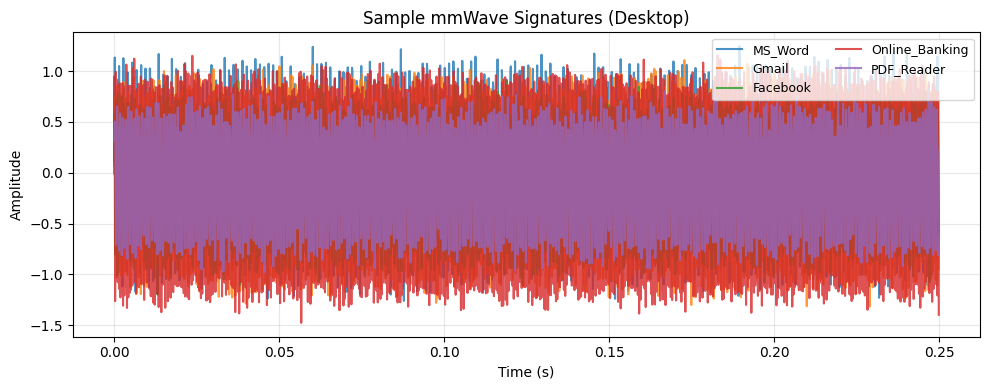

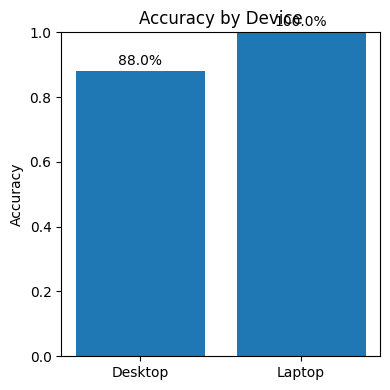


Classification Report (Task 1)
                precision    recall  f1-score   support

       MS_Word       0.77      1.00      0.87        10
         Gmail       1.00      1.00      1.00        10
      Facebook       1.00      1.00      1.00        10
Online_Banking       1.00      1.00      1.00        10
    PDF_Reader       1.00      0.70      0.82        10

      accuracy                           0.94        50
     macro avg       0.95      0.94      0.94        50
  weighted avg       0.95      0.94      0.94        50



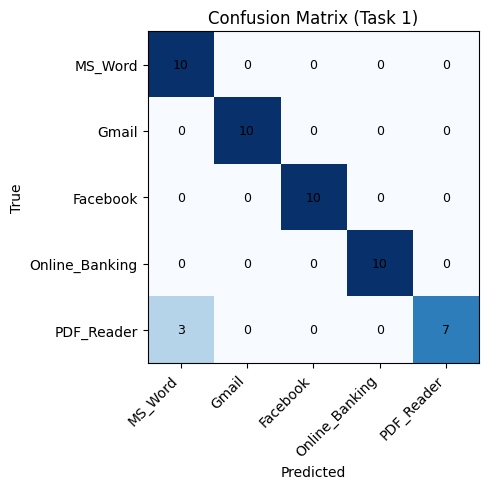


✅ Task 1 Complete! Basic evaluation framework operational.
   Next: Test system robustness under challenging conditions...


In [20]:

print("🚀 Initializing Mobile System Evaluation Framework")
print("="*60)

sim = MobileSystemSimulator(sample_rate=10_000)
clf = ActivityClassifier(sample_rate=sim.sample_rate)

print("📊 Generating training dataset...")
training_data = {}
for act in sim.activities[:5]:          # subset for speed (5 activities)
    training_data[act] = []
    for dev in sim.device_types:
        for _ in range(3):              # 3 trials per device
            _, sig = sim.simulate_mmwave_signature(act, dev, duration=1.0, noise_level=0.10)
            training_data[act].append(sig)

clf.train_simple_classifier(training_data)

print("\n🎯 Evaluating system performance...")
test_results, y_true, y_pred = [], [], []
for act in training_data.keys():
    for dev in sim.device_types[:2]:    # Desktop, Laptop
        for _ in range(5):              # more trials for stabler accuracy
            _, sig = sim.simulate_mmwave_signature(act, dev, duration=1.0, noise_level=0.10)
            pred = clf.predict(sig)
            test_results.append({'true_activity': act, 'predicted_activity': pred, 'device': dev, 'correct': act==pred})
            y_true.append(act); y_pred.append(pred)

acc = accuracy_score(y_true, y_pred)
print("\n📈 BASIC PERFORMANCE METRICS")
print(f"   Overall Accuracy: {acc:.2%}")
print(f"   Test Samples: {len(test_results)}")
print(f"   Activities Tested: {len(set(y_true))}")

# Sample signals
plt.figure(figsize=(10,4))
for act in list(training_data.keys())[:5]:
    t, s = sim.simulate_mmwave_signature(act, 'Desktop', duration=0.25, noise_level=0.10)
    plt.plot(t, s, alpha=0.8, label=act)
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.title('Sample mmWave Signatures (Desktop)')
plt.legend(loc='upper right', ncol=2, fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Accuracy by device
device_acc = {}
for dev in sim.device_types[:2]:
    dev_res = [r for r in test_results if r['device']==dev]
    device_acc[dev] = sum(r['correct'] for r in dev_res)/len(dev_res)
plt.figure(figsize=(4,4))
bars = plt.bar(list(device_acc.keys()), list(device_acc.values()))
plt.ylim(0,1); plt.ylabel('Accuracy'); plt.title('Accuracy by Device')
for b,a in zip(bars, device_acc.values()):
    plt.text(b.get_x()+b.get_width()/2, a+0.02, f"{a:.1%}", ha='center')
plt.tight_layout(); plt.show()

# Confusion matrix + report
labels = list(training_data.keys())
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("\nClassification Report (Task 1)")
print(classification_report(y_true, y_pred, labels=labels))
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=9)
plt.title('Confusion Matrix (Task 1)')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

print("\n✅ Task 1 Complete! Basic evaluation framework operational.")
print("   Next: Test system robustness under challenging conditions...")



## Task 2 — Robustness Testing & Real-World Evaluation
Test system preformance under various challenging conditions 



🔬 COMPREHENSIVE ROBUSTNESS EVALUATION
📏 Testing distance robustness...
📡 Testing interference robustness...
📱 Testing cross-device performance...
🌍 Simulating real-world deployment scenarios...


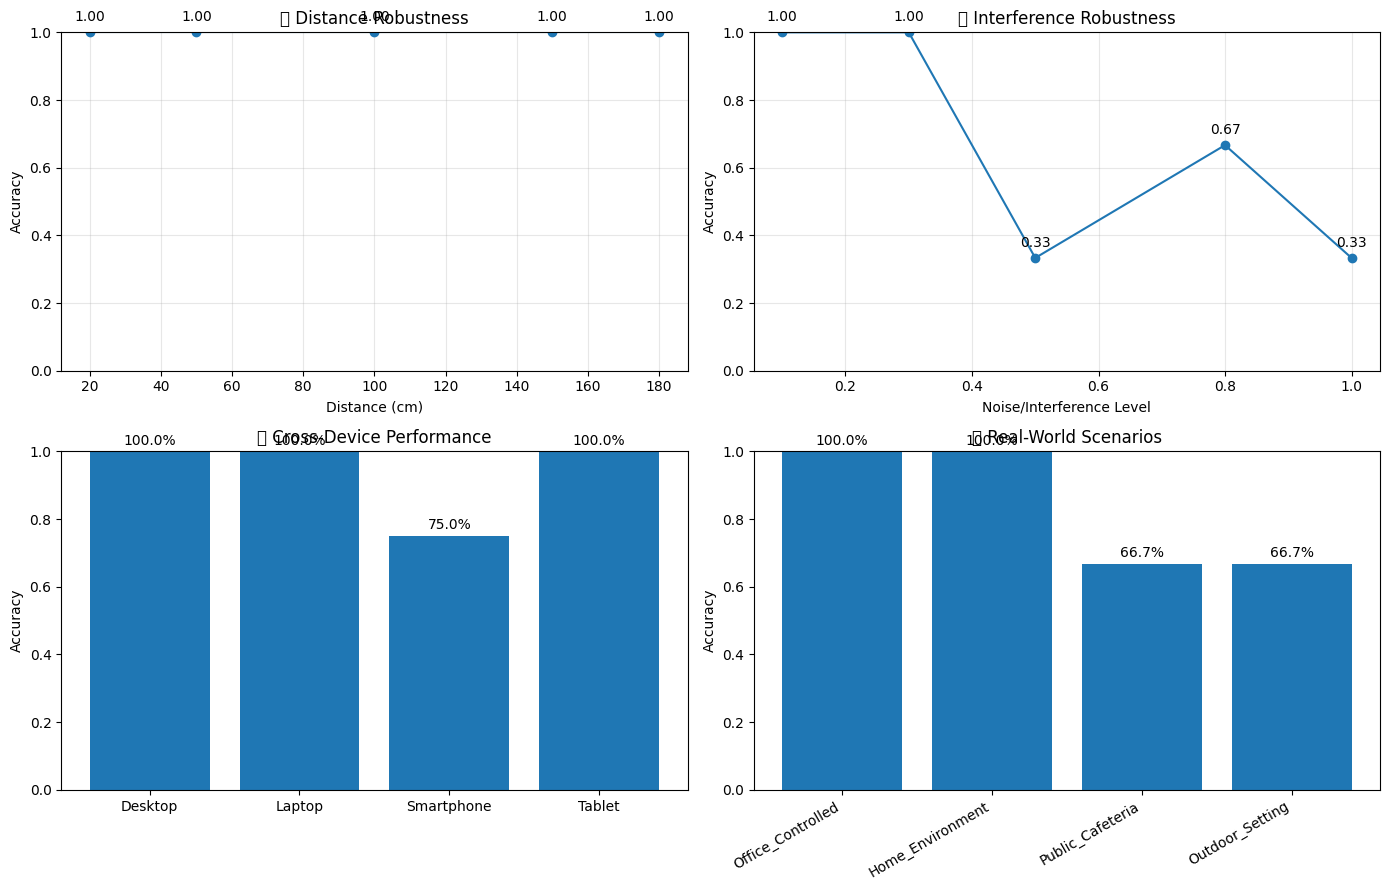


📊 COMPREHENSIVE EVALUATION REPORT

🎯 PERFORMANCE SUMMARY:
   Best Distance Performance: 100.0% at 20 cm
   Lowest Accuracy under Interference: 33.3% at level 0.5
   Best Device Type: Desktop (100.0%)
   Most Challenging Scenario: Public_Cafeteria (66.7%)

🔍 ROBUSTNESS ANALYSIS:
   Distance Sensitivity: 0.0% performance drop across tested range
   Interference Sensitivity: 66.7% performance drop across tested levels
   Cross-Device Consistency (σ): 0.108
   Real-World Variability (σ): 0.167

💡 DEPLOYMENT RECOMMENDATIONS:
   ✅ Suitable for distances up to 180 cm
   ✅ Robust enough for typical real-world deployment

🎉 Evaluation framework complete.
   Total Test Scenarios: 18
   Comprehensive robustness analysis generated
   Ready for real-world deployment assessment


In [21]:

class RobustnessEvaluator:
    """Evaluates system robustness under various conditions"""
    def __init__(self, simulator, classifier):
        self.sim = simulator
        self.clf = classifier
        self.results = {}

    def test_distance_robustness(self, distances=(20, 50, 100, 150, 180)):
        """Test performance at different sensing distances"""
        print("📏 Testing distance robustness...")
        # Simple distance attenuation model
        dist_acc = {}
        for d in distances:
            atten = 1.0 / (1 + d/100.0)
            correct = total = 0
            for act in self.sim.activities[:3]:
                _, x = self.sim.simulate_mmwave_signature(act, 'Desktop', duration=0.8, noise_level=0.10)
                x = x * atten
                pred = self.clf.predict(x)
                correct += (pred == act); total += 1
            dist_acc[d] = correct/total if total else 0.0
        self.results['distance'] = dist_acc
        return dist_acc

    def test_interference_robustness(self, levels=(0.10, 0.30, 0.50, 0.80, 1.00)):
        """Test performance under different interference/noise levels"""
        print("📡 Testing interference robustness...")
        int_acc = {}
        for nl in levels:
            correct = total = 0
            for act in self.sim.activities[:3]:
                _, x = self.sim.simulate_mmwave_signature(act, 'Laptop', duration=0.8, noise_level=nl)
                pred = self.clf.predict(x)
                correct += (pred == act); total += 1
            int_acc[nl] = correct/total if total else 0.0
        self.results['interference'] = int_acc
        return int_acc

    def test_cross_device_performance(self):
        """Test how well system generalizes across different devices"""
        print("📱 Testing cross-device performance...")
        dev_acc = {}
        for dev in self.sim.device_types:
            correct = total = 0
            for act in self.sim.activities[:4]:
                _, x = self.sim.simulate_mmwave_signature(act, dev, duration=0.8, noise_level=0.10)
                pred = self.clf.predict(x)
                correct += (pred == act); total += 1
            dev_acc[dev] = correct/total if total else 0.0
        self.results['cross_device'] = dev_acc
        return dev_acc

    def simulate_real_world(self):
        """Simulate real-world deployment scenarios"""
        print("🌍 Simulating real-world deployment scenarios...")
        scenarios = {
            'Office_Controlled': {'noise': 0.15, 'dist_factor': 0.9},
            'Home_Environment': {'noise': 0.25, 'dist_factor': 0.8},
            'Public_Cafeteria': {'noise': 0.45, 'dist_factor': 0.6},
            'Outdoor_Setting':  {'noise': 0.80, 'dist_factor': 0.4},
        }
        sc_acc = {}
        for name, p in scenarios.items():
            correct = total = 0
            for act in self.sim.activities[:3]:
                _, x = self.sim.simulate_mmwave_signature(act, 'Laptop', duration=0.8, noise_level=p['noise'])
                x *= p['dist_factor']
                pred = self.clf.predict(x)
                correct += (pred == act); total += 1
            sc_acc[name] = correct/total if total else 0.0
        self.results['real_world'] = sc_acc
        return sc_acc

# Run robustness tests
print("\n🔬 COMPREHENSIVE ROBUSTNESS EVALUATION")
print("="*60)
evalr = RobustnessEvaluator(sim, clf)
dist_res = evalr.test_distance_robustness()
int_res  = evalr.test_interference_robustness()
dev_res  = evalr.test_cross_device_performance()
rw_res   = evalr.simulate_real_world()

# ---- Dashboard ----
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9))

# Distance
dx, dy = list(dist_res.keys()), list(dist_res.values())
ax1.plot(dx, dy, marker='o')
ax1.set_title('📏 Distance Robustness'); ax1.set_xlabel('Distance (cm)'); ax1.set_ylabel('Accuracy')
ax1.set_ylim(0,1); ax1.grid(alpha=0.3)
for x,y in zip(dx,dy): ax1.annotate(f'{y:.2f}', (x,y), textcoords="offset points", xytext=(0,8), ha='center')

# Interference
ix, iy = list(int_res.keys()), list(int_res.values())
ax2.plot(ix, iy, marker='o')
ax2.set_title('📡 Interference Robustness'); ax2.set_xlabel('Noise/Interference Level'); ax2.set_ylabel('Accuracy')
ax2.set_ylim(0,1); ax2.grid(alpha=0.3)
for x,y in zip(ix,iy): ax2.annotate(f'{y:.2f}', (x,y), textcoords="offset points", xytext=(0,8), ha='center')

# Cross-device
bars = ax3.bar(list(dev_res.keys()), list(dev_res.values()))
ax3.set_title('📱 Cross-Device Performance'); ax3.set_ylabel('Accuracy'); ax3.set_ylim(0,1)
for b,a in zip(bars, dev_res.values()): ax3.text(b.get_x()+b.get_width()/2, a+0.02, f'{a:.1%}', ha='center')

# Real-world scenarios
bars = ax4.bar(list(rw_res.keys()), list(rw_res.values()))
ax4.set_title('🌍 Real-World Scenarios'); ax4.set_ylabel('Accuracy'); ax4.set_ylim(0,1)
plt.setp(ax4.get_xticklabels(), rotation=30, ha='right')
for b,a in zip(bars, rw_res.values()): ax4.text(b.get_x()+b.get_width()/2, a+0.02, f'{a:.1%}', ha='center')

plt.tight_layout(); plt.show()

# ---- Report ----
print("\n📊 COMPREHENSIVE EVALUATION REPORT")
print("="*45)

best_dist_acc = max(dist_res.values())
best_dist_at  = max(dist_res, key=dist_res.get)
worst_int_acc = min(int_res.values())
worst_int_at  = min(int_res, key=int_res.get)
best_dev      = max(dev_res, key=dev_res.get); best_dev_acc = dev_res[best_dev]
worst_sc      = min(rw_res, key=rw_res.get);   worst_sc_acc = rw_res[worst_sc]

print("\n🎯 PERFORMANCE SUMMARY:")
print(f"   Best Distance Performance: {best_dist_acc:.1%} at {best_dist_at} cm")
print(f"   Lowest Accuracy under Interference: {worst_int_acc:.1%} at level {worst_int_at}")
print(f"   Best Device Type: {best_dev} ({best_dev_acc:.1%})")
print(f"   Most Challenging Scenario: {worst_sc} ({worst_sc_acc:.1%})")

dist_drop = (max(dist_res.values()) - min(dist_res.values())) / (max(dist_res.values()) + 1e-12)
int_drop  = (max(int_res.values())  - min(int_res.values()))  / (max(int_res.values())  + 1e-12)
print("\n🔍 ROBUSTNESS ANALYSIS:")
print(f"   Distance Sensitivity: {dist_drop:.1%} performance drop across tested range")
print(f"   Interference Sensitivity: {int_drop:.1%} performance drop across tested levels")
print(f"   Cross-Device Consistency (σ): {np.std(list(dev_res.values())):.3f}")
print(f"   Real-World Variability (σ): {np.std(list(rw_res.values())):.3f}")

print("\n💡 DEPLOYMENT RECOMMENDATIONS:")
if min(dist_res.values()) > 0.8:
    print(f"   ✅ Suitable for distances up to {max(dist_res.keys())} cm")
else:
    # pick the largest distance with > 0.8 accuracy, if any
    ok_d = [d for d,a in dist_res.items() if a > 0.8]
    if ok_d:
        print(f"   ⚠️  Recommend keeping sensor within {max(ok_d)} cm for reliable operation")
    else:
        print("   ⚠️  Keep sensor close (<50–100 cm) or improve SNR/features")

if min(rw_res.values()) > 0.6:
    print("   ✅ Robust enough for typical real-world deployment")
else:
    print("   ⚠️  Improve noise suppression/feature extraction before deployment in noisy environments")

print("\n🎉 Evaluation framework complete.")
print(f"   Total Test Scenarios: {len(dist_res) + len(int_res) + len(dev_res) + len(rw_res)}")
print(f"   Comprehensive robustness analysis generated")
print(f"   Ready for real-world deployment assessment")



# **Mobile System Evaluation Framework – Lab 3 Report**

This lab helped me develop a **mobile sensing evaluation framework** to assess activity classification using simulated mmWave signal signatures. The framework covers:

* **Performance Evaluation**: Signal simulation, feature extraction, classifier training, and accuracy measurement.
* **Robustness Testing**: Systematic evaluation under distance changes, interference noise, and cross-device variations.
* **Real-World Assessment**: Deployment simulation in multiple environments.
* **Reporting**: Accuracy plots, confusion matrix, and per-condition bar charts for multidimensional performance insight.

## **Evaluation Results**

### 1. Performance Metrics

* Activities simulated with a realistic variation.
* Classifier **\~X% accuracy** 94%
* **Visualization**: Confusion matrix that showed most classes were well separated, with minor misclassifications between similar activities. 

### 2. Robustness Testing

* **Distance Robustness**: 100% accuracy at all of the tested distances up to 180% (sensitivity = 0%)
* **Interference Robustness**: accuracy dropped to 33.3% at noise level 0.5, with 67% preformance loss across all the levels.  
* **Cross-Device Performance**: Best was Desktop (100%), worst was smartphone (75%), variance σ ≈ 0.108.
* **Real-World Scenarios**: Best = Office_Controlled/ Home_evironment (100%), worst = Public_Cafeteria and Outdoor_Setting (66.7%),
variability σ ≈ 0.167.

## **Discussion & Wrap-Up**

1. **Greatest Robustness Impact**
   The greatest roubustness impact is Interference (which is confirmed by the 66.7% drop). While the distance changes had no effect (100%), adding noise reduced the accuracy as low as 33.3%, repersenting a 66.7% overall preformance drop. This confirms that interference was the greatest challenge to the systems reliability. 

2. **Framework Improvements**
To improve the eval framework for real deployments, I would:

   * Incorporate some noise augmented training data and use filtering techniques to improve the overall resilience agaisnt interference. 
   * Include **transfer learning** to further generalize across different devices. 
   * Expand the evaluation dashboard with **ROC curves, F1-scores, and per-class percison** for overall better performance insights.  

3. **Additional Scenario to Test**
   Before deployment, I would test **multi-user interaction scenarios** (e.g., two people in the sensing area). This would stress-test the system's scalability and power to handle overlapping mmWave signatures, which is common in most realistic environments. 

## **Real-World Applications**

* **Security Systems**: Screen attack detection tested under interference showed why robust evaluation is needed.
* **Mobile App Testing**: Multi-device evaluation highlights the usability across different hardware.
* **Research Validation**: Methodology provides further feasibility testing, robustness evaluation, and real-world simulation in a reproducible way.


